In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from io import BytesIO
from PIL import Image, ImageDraw
import numpy as np

In [2]:
# === 🎨 Color Constants ===
COLOR_CLOSE = "#2196F3"        # Blue
COLOR_AHMA = "#880E4F"         # Deep Pink
COLOR_PROJECTION = "#FF9800"   # Orange
COLOR_CONVOLUTION = "#4CAF50"  # Green

# === 🧮 Configuration Constants ===
DEFAULT_IMAGE_SIZE = (128, 128)
DEFAULT_NUM_DAYS = 21   # Max bars per window (starting window)
ENDING_NUM_DAYS = 5    # Min bars allowed (final tier)
WINDOW_STRIDE = 2       # Decrease step per tier



In [3]:
def plot_pattern_image(df, num_days=DEFAULT_NUM_DAYS, size=DEFAULT_IMAGE_SIZE, include_close=True, save_path=None):
    df_window = df.tail(num_days)

    fig, ax = plt.subplots(figsize=(size[0] / 64, size[1] / 64), dpi=64)

    if include_close and "Close" in df_window.columns:
        ax.plot(df_window["Close"], color=COLOR_CLOSE, linewidth=1.5)

    if "AHMA" in df_window.columns:
        ax.plot(df_window["AHMA"], color=COLOR_AHMA, linewidth=1.5)

    if "Leavitt_Projection" in df_window.columns:
        ax.plot(df_window["Leavitt_Projection"], color=COLOR_PROJECTION, linewidth=1.5)

    if "Leavitt_Convolution" in df_window.columns:
        ax.plot(df_window["Leavitt_Convolution"], color=COLOR_CONVOLUTION, linewidth=1.5)

    ax.axis("off")
    plt.tight_layout(pad=0)

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", pad_inches=0)
        plt.close(fig)
    else:
        plt.show()

def load_and_plot_pattern(csv_path, num_days=DEFAULT_NUM_DAYS, image_size=DEFAULT_IMAGE_SIZE, include_close=True):
    df = pd.read_csv(csv_path, encoding="utf-8")

    required_cols = ["AHMA", "Leavitt_Projection", "Leavitt_Convolution"]
    if include_close:
        required_cols.append("Close")
    
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required column(s): {missing}")
    
    plot_pattern_image(df, num_days=num_days, size=image_size, include_close=include_close)


In [4]:
def plot_pattern_pil(
    df,
    num_days=DEFAULT_NUM_DAYS,
    size=DEFAULT_IMAGE_SIZE,
    include_close=True,
    upscale=4,
):
    """
    Lightweight PIL-only plotting function - replacement for matplotlib version
    """

    df_window = df.tail(num_days)

    # Draw at higher resolution
    high_res_size = (size[0] * upscale, size[1] * upscale)

    # Create blank white image
    img = Image.new("RGB", high_res_size, "white")
    draw = ImageDraw.Draw(img)

    # Get data ranges for scaling
    all_values = []
    series_data = {}

    if include_close and "Close" in df_window.columns:
        series_data["Close"] = (df_window["Close"].values, COLOR_CLOSE)
        all_values.extend(df_window["Close"].values)

    if "AHMA" in df_window.columns:
        series_data["AHMA"] = (df_window["AHMA"].values, COLOR_AHMA)
        all_values.extend(df_window["AHMA"].values)

    if "Leavitt_Projection" in df_window.columns:
        series_data["Leavitt_Projection"] = (
            df_window["Leavitt_Projection"].values,
            COLOR_PROJECTION,
        )
        all_values.extend(df_window["Leavitt_Projection"].values)

    if "Leavitt_Convolution" in df_window.columns:
        series_data["Leavitt_Convolution"] = (
            df_window["Leavitt_Convolution"].values,
            COLOR_CONVOLUTION,
        )
        all_values.extend(df_window["Leavitt_Convolution"].values)

    if not all_values:
        return np.array(img) / 255.0

    # Scale data to image coordinates
    min_val = min(all_values)
    max_val = max(all_values)
    val_range = max_val - min_val if max_val != min_val else 1

    width, height = size
    high_res_width, high_res_height = high_res_size

    # Draw each series
    for series_name, (values, color) in series_data.items():
        if len(values) < 2:
            continue

        # Convert to screen coordinates (SCALE BY UPSCALE)
        points = []
        for i, val in enumerate(values):
            x = int((i / (len(values) - 1)) * (width - 1) * upscale)
            y = int(
                (high_res_height - 1)
                - ((val - min_val) / val_range) * (high_res_height - 1)
            )
            points.append((x, y))

        # Draw the line
        if len(points) > 1:
            draw.line(points, fill=color, width=2 * upscale)

    # Downsample with LANCZOS for anti-aliasing
    img = img.resize(size, Image.Resampling.LANCZOS)
    # Convert to numpy array and normalize
    img_array = np.array(img) / 255.0
    return img_array


def load_and_plot_pattern_pil(
    csv_path,
    num_days=DEFAULT_NUM_DAYS,
    image_size=DEFAULT_IMAGE_SIZE,
    include_close=True,
    upscale=4,
):
    df = pd.read_csv(csv_path, encoding="utf-8")

    required_cols = ["AHMA", "Leavitt_Projection", "Leavitt_Convolution"]
    if include_close:
        required_cols.append("Close")

    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required column(s): {missing}")

    img_array = plot_pattern_pil(
        df,
        num_days=num_days,
        size=image_size,
        include_close=include_close,
        upscale=upscale,
    )
    # Display the image
    # Image.fromarray((img_array * 255).astype(np.uint8)).show()
    # Display the image using matplotlib
    plt.imshow(img_array)
    plt.axis("off")
    plt.title(f"{num_days} bars")
    plt.show()
    # Optionally, return the array if you want to use it elsewhere
    return img_array

In [5]:
signal_path = "../../examples/AUD_JPY_processed_signals.csv"

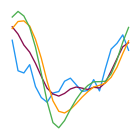

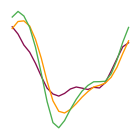

In [6]:
# 🔵 With Close
load_and_plot_pattern(signal_path, include_close=True)

# 🔴 Without Close
load_and_plot_pattern(signal_path, include_close=False)


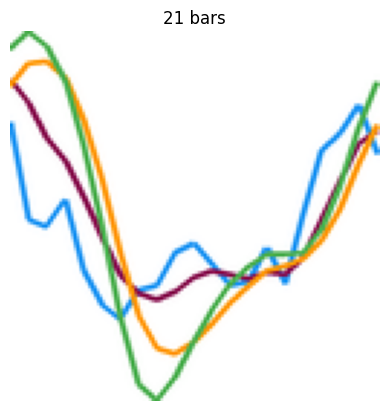

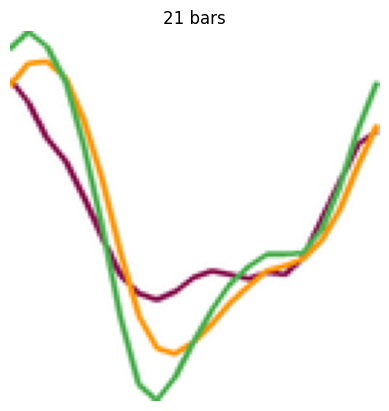

array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [0.98431373, 0.99215686, 0.98431373],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [0.99215686, 0.99607843, 0.99215686],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.99215686, 0.99607843, 0.99215686],
        [1.        , 1.        , 1.        ],
        [0.69411765, 0.8627451 , 0.69803922],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1

In [7]:
# 🔵 With Close
load_and_plot_pattern_pil(signal_path, include_close=True, upscale=4)

# 🔴 Without Close
load_and_plot_pattern_pil(signal_path, include_close=False)

In [8]:
def plot_pattern_image_array(df, num_days=28, size=(128, 128), include_close=True):
    df_window = df.tail(num_days)

    fig, ax = plt.subplots(figsize=(size[0] / 64, size[1] / 64), dpi=64)

    if include_close and "Close" in df_window.columns:
        ax.plot(df_window["Close"], color=COLOR_CLOSE, linewidth=1.5)
    if "AHMA" in df_window.columns:
        ax.plot(df_window["AHMA"], color=COLOR_AHMA, linewidth=1.5)
    if "Leavitt_Projection" in df_window.columns:
        ax.plot(df_window["Leavitt_Projection"], color=COLOR_PROJECTION, linewidth=1.5)
    if "Leavitt_Convolution" in df_window.columns:
        ax.plot(df_window["Leavitt_Convolution"], color=COLOR_CONVOLUTION, linewidth=1.5)

    ax.axis("off")
    plt.tight_layout(pad=0)

    buf = BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight", pad_inches=0)
    plt.close(fig)

    buf.seek(0)
    img = Image.open(buf).convert("RGB")
    img = img.resize(size)  # Ensure it's exactly size (128x128)
    img_array = np.array(img) / 255.0  # Normalize to 0-1
    return img_array

In [9]:
from PIL import Image, ImageDraw
import numpy as np


def plot_pattern_image_array_pil(
    df, num_days=28, size=(128, 128), include_close=True, upscale=4
):
    df_window = df.tail(num_days)
    high_res_size = (size[0] * upscale, size[1] * upscale)
    img = Image.new("RGB", high_res_size, "white")
    draw = ImageDraw.Draw(img)

    all_values = []
    series_data = {}
    if include_close and "Close" in df_window.columns:
        series_data["Close"] = (df_window["Close"].values, COLOR_CLOSE)
        all_values.extend(df_window["Close"].values)
    if "AHMA" in df_window.columns:
        series_data["AHMA"] = (df_window["AHMA"].values, COLOR_AHMA)
        all_values.extend(df_window["AHMA"].values)
    if "Leavitt_Projection" in df_window.columns:
        series_data["Leavitt_Projection"] = (
            df_window["Leavitt_Projection"].values,
            COLOR_PROJECTION,
        )
        all_values.extend(df_window["Leavitt_Projection"].values)
    if "Leavitt_Convolution" in df_window.columns:
        series_data["Leavitt_Convolution"] = (
            df_window["Leavitt_Convolution"].values,
            COLOR_CONVOLUTION,
        )
        all_values.extend(df_window["Leavitt_Convolution"].values)
    if not all_values:
        img = img.resize(size, Image.Resampling.LANCZOS)
        return np.array(img) / 255.0

    min_val = min(all_values)
    max_val = max(all_values)
    val_range = max_val - min_val if max_val != min_val else 1

    high_res_width, high_res_height = high_res_size

    for series_name, (values, color) in series_data.items():
        if len(values) < 2:
            continue
        points = []
        for i, val in enumerate(values):
            x = int((i / (len(values) - 1)) * (high_res_width - 1))
            y = int(
                (high_res_height - 1)
                - ((val - min_val) / val_range) * (high_res_height - 1)
            )
            points.append((x, y))
        if len(points) > 1:
            draw.line(points, fill=color, width=2 * upscale)

    img = img.resize(size, Image.Resampling.LANCZOS)
    img_array = np.array(img) / 255.0
    return img_array

In [10]:
df = pd.read_csv(signal_path, encoding="utf-8")

# Get image array from last 28 bars
image_array = plot_pattern_image_array(df, num_days=28)

# Expand dims for CNN model: (1, 128, 128, 3)
image_batch = np.expand_dims(image_array, axis=0)

# Model inference: model.predict(image_batch)

In [11]:
def generate_sliding_windows(df, image_size=(128, 128), include_close=True):
    """
    Yields (window_size, image_array) tuples from DEFAULT_NUM_DAYS down to ENDING_NUM_DAYS (inclusive).
    """
    results = []
    for window_size in range(DEFAULT_NUM_DAYS, ENDING_NUM_DAYS - 1, -WINDOW_STRIDE):
        img = plot_pattern_image_array(
            df,
            num_days=window_size,
            size=image_size,
            include_close=include_close
        )
        results.append((window_size, img))
    return results

In [12]:
def generate_sliding_windows_pil(df, image_size=(128, 128), include_close=True):
    """
    Yields (window_size, image_array) tuples from DEFAULT_NUM_DAYS down to ENDING_NUM_DAYS (inclusive).
    """
    results = []
    for window_size in range(DEFAULT_NUM_DAYS, ENDING_NUM_DAYS - 1, -WINDOW_STRIDE):
        img = plot_pattern_image_array_pil(
            df, num_days=window_size, size=image_size, include_close=include_close
        )
        results.append((window_size, img))
    return results

In [13]:
windows = generate_sliding_windows(df, include_close=False)

for bars, image in windows:
    print(f"Window: {bars} bars → Image shape: {image.shape}")
    # prediction = model.predict(np.expand_dims(image, axis=0))


Window: 21 bars → Image shape: (128, 128, 3)
Window: 19 bars → Image shape: (128, 128, 3)
Window: 17 bars → Image shape: (128, 128, 3)
Window: 15 bars → Image shape: (128, 128, 3)
Window: 13 bars → Image shape: (128, 128, 3)
Window: 11 bars → Image shape: (128, 128, 3)
Window: 9 bars → Image shape: (128, 128, 3)
Window: 7 bars → Image shape: (128, 128, 3)
Window: 5 bars → Image shape: (128, 128, 3)


In [14]:
windows_pil = generate_sliding_windows_pil(df, include_close=False)

for bars, image in windows:
    print(f"Window: {bars} bars → Image shape: {image.shape}")
    # prediction = model.predict(np.expand_dims(image, axis=0))

Window: 21 bars → Image shape: (128, 128, 3)
Window: 19 bars → Image shape: (128, 128, 3)
Window: 17 bars → Image shape: (128, 128, 3)
Window: 15 bars → Image shape: (128, 128, 3)
Window: 13 bars → Image shape: (128, 128, 3)
Window: 11 bars → Image shape: (128, 128, 3)
Window: 9 bars → Image shape: (128, 128, 3)
Window: 7 bars → Image shape: (128, 128, 3)
Window: 5 bars → Image shape: (128, 128, 3)


In [15]:
def inspect_window(window_tuple, model=None, decode_fn=None, threshold=0.8):
    """
    Prints stride + window size, shows the image, and optionally runs model inference.
    """
    window_size, img = window_tuple
    stride = DEFAULT_NUM_DAYS - window_size

    print(f"🪟 Window Size: {window_size} bars")
    print(f"↪️  Stride from left: {stride} bars")

    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(img)
    plt.title(f"{window_size} bars (stride={stride})")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    if model:
        input_tensor = np.expand_dims(img, axis=0)
        preds = model.predict(input_tensor)

        label = decode_fn(preds) if decode_fn else preds.argmax()
        confidence = preds.max()

        print(f"🧠 Model Prediction: {label} (confidence = {confidence:.2f})")
        if confidence > threshold:
            print("✅ Exceeds confidence threshold → inference accepted")
        else:
            print("❌ Below threshold → continue sliding")

🪟 Window Size: 11 bars
↪️  Stride from left: 10 bars


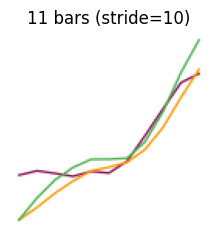

🪟 Window Size: 11 bars
↪️  Stride from left: 10 bars


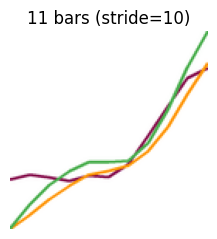

In [16]:
# Inspect one (e.g., the 3rd tier)
inspect_window(windows[5])  

# Inspect one (e.g., the 3rd tier)
inspect_window(windows_pil[5])

🪟 Window Size: 21 bars
↪️  Stride from left: 0 bars


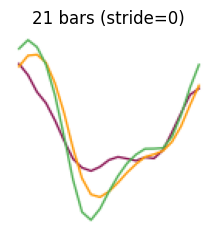

🪟 Window Size: 19 bars
↪️  Stride from left: 2 bars


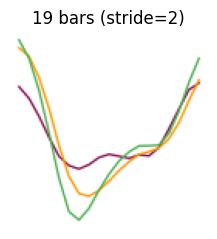

🪟 Window Size: 17 bars
↪️  Stride from left: 4 bars


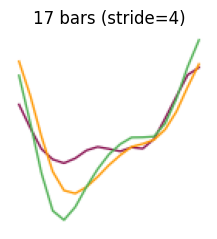

🪟 Window Size: 15 bars
↪️  Stride from left: 6 bars


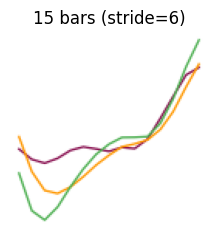

🪟 Window Size: 13 bars
↪️  Stride from left: 8 bars


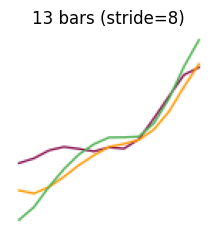

🪟 Window Size: 11 bars
↪️  Stride from left: 10 bars


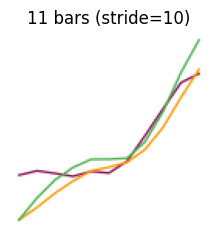

🪟 Window Size: 9 bars
↪️  Stride from left: 12 bars


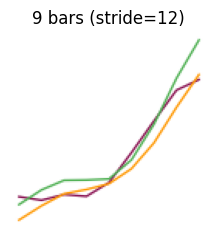

🪟 Window Size: 7 bars
↪️  Stride from left: 14 bars


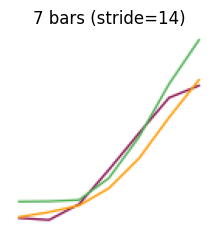

🪟 Window Size: 5 bars
↪️  Stride from left: 16 bars


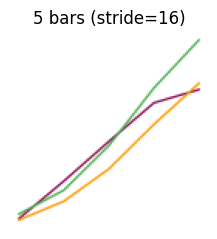

In [17]:
for win in windows:
    inspect_window(win)

🪟 Window Size: 21 bars
↪️  Stride from left: 0 bars


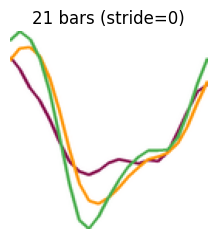

🪟 Window Size: 19 bars
↪️  Stride from left: 2 bars


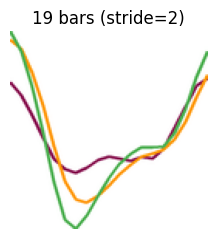

🪟 Window Size: 17 bars
↪️  Stride from left: 4 bars


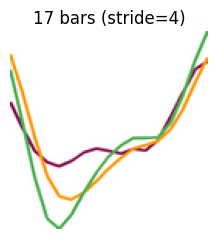

🪟 Window Size: 15 bars
↪️  Stride from left: 6 bars


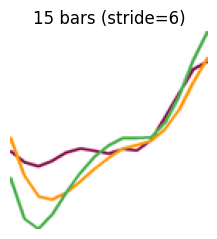

🪟 Window Size: 13 bars
↪️  Stride from left: 8 bars


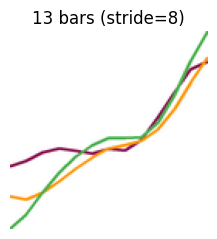

🪟 Window Size: 11 bars
↪️  Stride from left: 10 bars


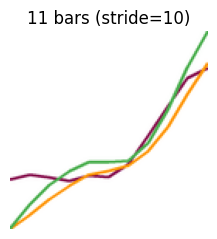

🪟 Window Size: 9 bars
↪️  Stride from left: 12 bars


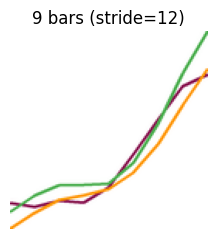

🪟 Window Size: 7 bars
↪️  Stride from left: 14 bars


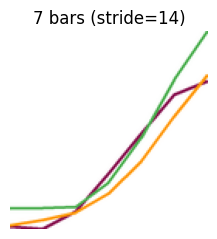

🪟 Window Size: 5 bars
↪️  Stride from left: 16 bars


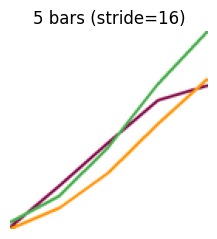

In [18]:
for win in windows_pil:
    inspect_window(win)